In [11]:
from keras.datasets import cifar10
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.optimizers import SGD, Adam, RMSprop

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def load_and_format(in_path):
    out_df = pd.read_json(in_path)
    out_images = out_df.apply(lambda c_row: [np.stack([c_row['band_1'],c_row['band_2']], -1).reshape((75,75,2))],1)
    out_images = np.stack(out_images).squeeze()
    return out_df, out_images


In [3]:
base_path = 'data/iceberg'

In [4]:
train_df, train_images = load_and_format(os.path.join(base_path, 'train.json'))
print('training', train_df.shape, 'loaded', train_images.shape)
test_df, test_images = load_and_format(os.path.join(base_path, 'test.json'))
print('testing', test_df.shape, 'loaded', test_images.shape)
train_df.sample(3)

training (1604, 5) loaded (1604, 75, 75, 2)
testing (8424, 4) loaded (8424, 75, 75, 2)


,band_1,band_2,id,inc_angle,is_iceberg
199,"[-23.31403, -22.291029, -20.707455, -24.229328...","[-28.120672, -27.396479, -28.506874, -30.74640...",bdc40587,40.9817,0
587,"[-26.870293, -28.578964, -25.443308, -27.18637...","[-23.772255, -22.944468, -21.165712, -22.55849...",94e0a5db,35.6314,0
1351,"[-27.849041, -28.235186, -25.83572, -25.83572,...","[-29.978146, -31.561813, -32.80481, -32.80481,...",c2b88693,43.7871,0


In [5]:
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
X_train, X_test, y_train, y_test = train_test_split(train_images,
                                                   to_categorical(train_df['is_iceberg']),
                                                    random_state = 2017,
                                                    test_size = 0.5
                                                   )
print('Train', X_train.shape, y_train.shape)
print('Validation', X_test.shape, y_test.shape)

Train (802, 75, 75, 2) (802, 2)
Validation (802, 75, 75, 2) (802, 2)


In [57]:
# float and normalization
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

In [59]:
# network

IMG_CHANNELS = 2
IMG_ROWS = 75
IMG_COLS = 75

#constant
BATCH_SIZE = 32
NB_EPOCH = 50
NB_CLASSES = 2
VERBOSE = 1
VALIDATION_SPLIT = 0.2
OPTIM = RMSprop()

model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same',
                 input_shape=(IMG_ROWS, IMG_COLS, IMG_CHANNELS)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))  
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(NB_CLASSES, activation = 'softmax'))
model.compile(loss='binary_crossentropy', optimizer=OPTIM,metrics=['accuracy'])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_11 (Conv2D)           (None, 75, 75, 32)        608       
_________________________________________________________________
activation_23 (Activation)   (None, 75, 75, 32)        0         
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 37, 37, 32)        0         
_________________________________________________________________
dropout_21 (Dropout)         (None, 37, 37, 32)        0         
_________________________________________________________________
flatten_10 (Flatten)         (None, 43808)             0         
_________________________________________________________________
dense_21 (Dense)             (None, 512)               22430208  
_________________________________________________________________
activation_24 (Activation)   (None, 512)               0         
__________

In [60]:
# train
#optim = SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
history = model.fit(X_train, y_train, batch_size=BATCH_SIZE,
	epochs=NB_EPOCH, validation_split=VALIDATION_SPLIT, 
	verbose=VERBOSE)
 
print('Testing...')
score = model.evaluate(X_test, y_test,
                     batch_size=BATCH_SIZE, verbose=VERBOSE)
print("\nTest score:", score[0])
print('Test accuracy:', score[1])

#server.launch(model)


Train on 641 samples, validate on 161 samples
Epoch 1/50
641/641 [==============================] - 1s - loss: 1.2657 - acc: 0.5507 - val_loss: 1.1193 - val_acc: 0.5155
Epoch 2/50
641/641 [==============================] - 0s - loss: 0.6654 - acc: 0.5897 - val_loss: 0.6480 - val_acc: 0.5155
Epoch 3/50
641/641 [==============================] - 0s - loss: 0.6014 - acc: 0.6630 - val_loss: 0.7357 - val_acc: 0.5155
Epoch 4/50
641/641 [==============================] - 0s - loss: 0.5842 - acc: 0.6505 - val_loss: 0.5146 - val_acc: 0.7205
Epoch 5/50
641/641 [==============================] - 0s - loss: 0.5378 - acc: 0.7207 - val_loss: 0.5510 - val_acc: 0.7081
Epoch 6/50
641/641 [==============================] - 0s - loss: 0.5034 - acc: 0.7457 - val_loss: 0.5502 - val_acc: 0.7019
Epoch 7/50
641/641 [==============================] - 0s - loss: 0.5366 - acc: 0.7067 - val_loss: 0.5145 - val_acc: 0.7205
Epoch 8/50
641/641 [==============================] - 0s - loss: 0.4606 - acc: 0.7722 - val_l

In [61]:
#save model
#model_json = model.to_json()
#open('iceberg_architecture.json', 'w').write(model_json)
#model.save_weights('iceberg_weights.h5', overwrite=True)

dict_keys(['val_acc', 'loss', 'acc', 'val_loss'])


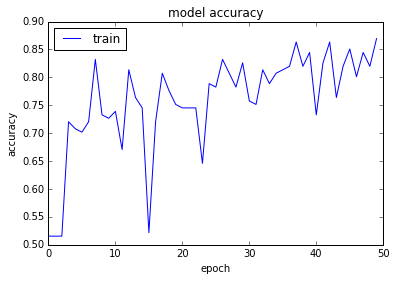

In [62]:
# list all data in history
print(history.history.keys())
# summarize history for accuracy
#plt.plot(mo)
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()


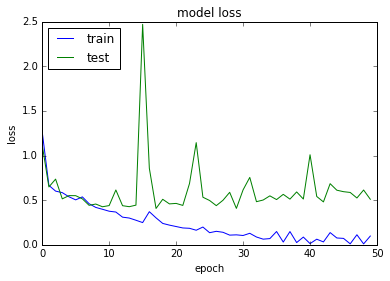

In [63]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [69]:
test_predictions = model.predict(test_images)

In [70]:
pred_df = test_df[['id']].copy()
pred_df['is_iceberg'] = test_predictions[:,1]
pred_df.to_csv('predictions.csv', index = False)
pred_df.sample(100)

,id,is_iceberg
1237,a0f39ace,0.0
6718,4ec47c40,0.0
6688,a196ac29,0.0
5706,33a9c441,0.0
7995,035c79d2,1.0
8269,d73eec96,0.0
3875,8a581e96,0.0
443,c60100ad,0.0
3603,eb9e1acc,0.0
1779,3c72f288,1.0
